In [1]:
import numpy as np
from numpy import pi, cos, sqrt, zeros
from numpy.random import randn

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size':14})

from scipy import signal
from scipy.io import loadmat

from filters import LMS, NLMS, RLS

In [2]:
def exp5(a, mu_0, epsilon, L, total_time, N):
    n = np.arange(total_time)
    
    adaptation_delay = 100
    
    EMSE_LMS = zeros(total_time - adaptation_delay)
    EMSE_NLMS = zeros(total_time - adaptation_delay)
    EMSE_RLS = zeros(total_time - adaptation_delay)
    for i in range(N):
        sigma_u = sqrt(1)
        u = randn(total_time) * sigma_u
        x = signal.lfilter(b=[sqrt(1 - a ** 2)], a=[1, -a], x=u)
        sigma_x = sigma_u

        sigma_v = sqrt(.01)
        v = randn(total_time) * sigma_v

        H = randn(100)
        H = H / np.linalg.norm(H)
        
        y = signal.lfilter(b=H, a=1, x=x)

        d = y + v

        M = len(H)
        lms_filter = LMS(M=M, mu=mu_0 / (M * sigma_x + epsilon))
        nlms_filter = NLMS(M=M, mu_0=mu_0, epsilon=epsilon)
        rls_filter = RLS(M=M, L=L, delta=1)

        for j in range(adaptation_delay, total_time):
            lms_filter.buffer(x[j], d[j])
            nlms_filter.buffer(x[j], d[j])
            rls_filter.buffer(x[j], d[j])

        sigma_o = sigma_v
        EMSE_LMS += (1 / N) * (np.square(lms_filter.e) - sigma_o ** 2)
        EMSE_NLMS += (1 / N) * (np.square(nlms_filter.e) - sigma_o ** 2)
        EMSE_RLS += (1 / N) * (np.square(rls_filter.e) - sigma_o ** 2)
        
    return n[adaptation_delay:], EMSE_LMS, EMSE_NLMS, EMSE_RLS

## Sinal nao correlacionado

Text(0.5, 0, 'n')

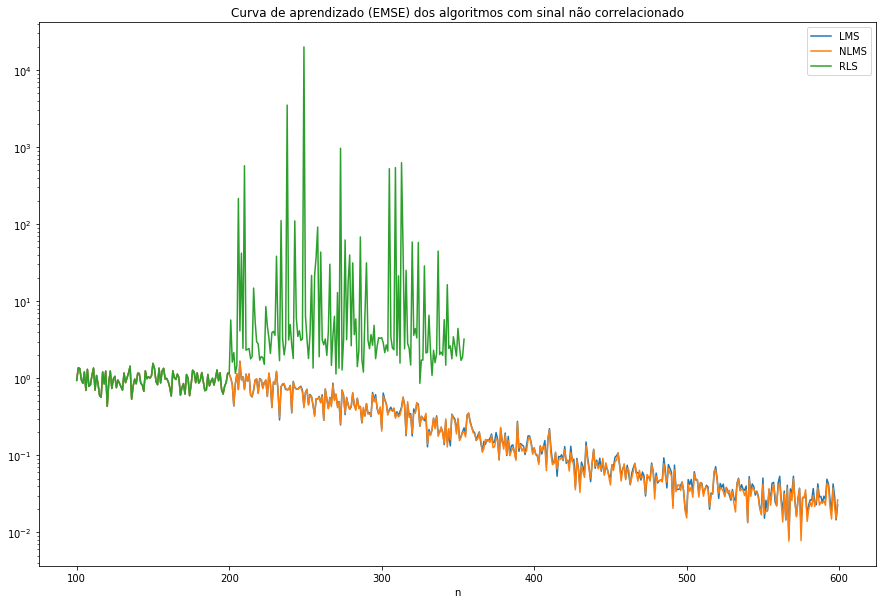

In [3]:
n, EMSE_LMS, EMSE_NLMS, EMSE_RLS = exp5(a=0, mu_0=1, epsilon=0, L=.9999, total_time=600, N=30)
plt.subplots(figsize=(15,10))
plt.semilogy(n, EMSE_LMS, n, EMSE_NLMS, n, EMSE_RLS)
plt.title('Curva de aprendizado (EMSE) dos algoritmos com sinal não correlacionado')
plt.legend(['LMS', 'NLMS', 'RLS'])
plt.xlabel('n')

## Sinal correlacinado

Text(0.5, 0, 'n')

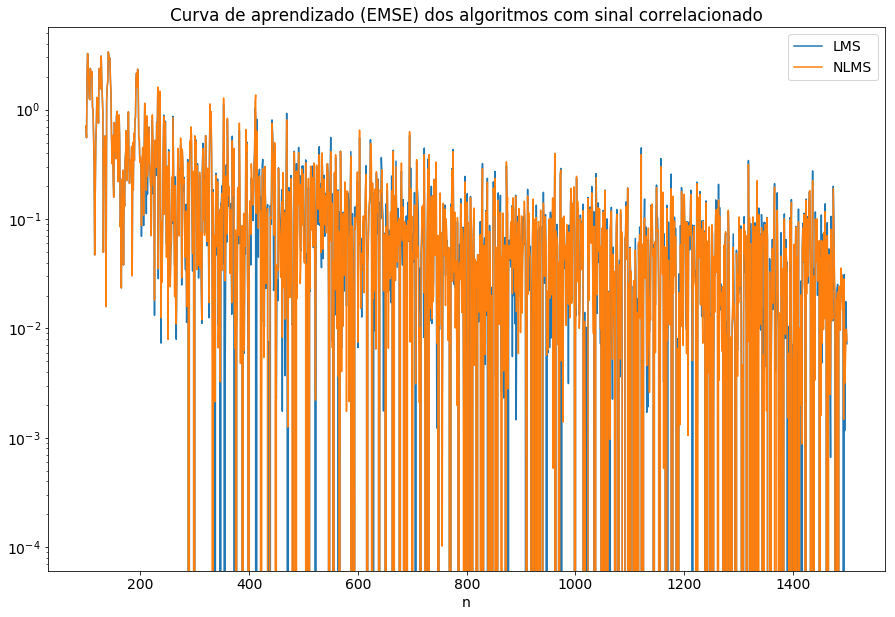

In [34]:
n, EMSE_LMS, EMSE_NLMS = exp5(a=.9, mu_0=.3, epsilon=0, total_time=1500, N=200)
plt.subplots(figsize=(15,10))
plt.semilogy(n, EMSE_LMS, n, EMSE_NLMS)
plt.title('Curva de aprendizado (EMSE) dos algoritmos com sinal correlacionado')
plt.legend(['LMS', 'NLMS'])
plt.xlabel('n')